# ひと目でわかるDGL1
http://torch.classcat.com/2019/06/02/dgl-tutorials-basics-1-first/

このチュートリアルのゴールは :

- DGL がどのように高位からのグラフ上の計算を可能にするか理解する。
- グラフのノードを分類するために DGL で単純なグラフニューラルネットワークを訓練する。

「Zachary の空手クラブ」問題から始めます。空手クラブは 34 メンバーを捉えて (クラブ外で相互作用する) メンバー間の対のリンクを文書化するソーシャルネットワークです。クラブは後でインストラクター (node 0) とクラブ会長 (node 33) により導かれる 2 つのコミュニティに分かれます。ネットワークはコミュニティを示すカラーで次のように可視化されます :



このタスクはソーシャルネットワーク自身が与えられたとき各メンバーがどちらの側 (0 or 33) に参加する傾向があるかを予測することです。_

## Step 1: DGL でグラフを作成する
Zachary の空手クラブのためのグラフの作成は次のようなものです :

In [1]:
import dgl

def build_karate_club_graph():
    g = dgl.DGLGraph()
    # add 34 nodes into the graph; nodes are labeled from 0~33
    g.add_nodes(34)
    # all 78 edges as a list of tuples
    edge_list = [(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2),
        (4, 0), (5, 0), (6, 0), (6, 4), (6, 5), (7, 0), (7, 1),
        (7, 2), (7, 3), (8, 0), (8, 2), (9, 2), (10, 0), (10, 4),
        (10, 5), (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2),
        (13, 3), (16, 5), (16, 6), (17, 0), (17, 1), (19, 0), (19, 1),
        (21, 0), (21, 1), (25, 23), (25, 24), (27, 2), (27, 23),
        (27, 24), (28, 2), (29, 23), (29, 26), (30, 1), (30, 8),
        (31, 0), (31, 24), (31, 25), (31, 28), (32, 2), (32, 8),
        (32, 14), (32, 15), (32, 18), (32, 20), (32, 22), (32, 23),
        (32, 29), (32, 30), (32, 31), (33, 8), (33, 9), (33, 13),
        (33, 14), (33, 15), (33, 18), (33, 19), (33, 20), (33, 22),
        (33, 23), (33, 26), (33, 27), (33, 28), (33, 29), (33, 30),
        (33, 31), (33, 32)]
    # add edges two lists of nodes: src and dst
    src, dst = tuple(zip(*edge_list))
    g.add_edges(src, dst)
    # edges are directional in DGL; make them bi-directional
    g.add_edges(dst, src)

    return g

Using backend: pytorch


新たに構築されたグラフのノードとエッジの数を出力表示できます :

In [2]:
G = build_karate_club_graph()
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

We have 34 nodes.
We have 156 edges.


それを networkx グラフに変換することによりグラフを可視化することもできます :

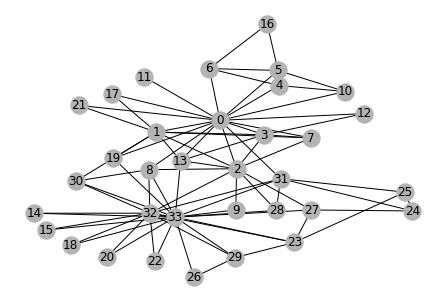

In [6]:
import networkx as nx
# Since the actual graph is undirected, we convert it for visualization
# purpose.
%matplotlib inline
nx_G = G.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

## Step 2: 特徴をノードまたはエッジに割り当てる
グラフニューラルネットワークは訓練のために特徴をノードとエッジに関連付けます。私達の分類例のために、各ノードの入力特徴を one-hot ベクトルとして割り当てます: ノード $v_i$ の特徴ベクトルは [0,…,1,…,0] で、そこでは $i^{th}$位置が 1 です。

DGL では、最初の次元に沿ったノード特徴をバッチ処理する特徴 tensor を使用して、総てのノードのために特徴を一度に追加できます。下のこのコードは総てのノードのために one-hot 特徴を追加します :

In [18]:
import torch

G.ndata['feat'] = torch.eye(34)

In [19]:
print(G.ndata["feat"])

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])


検証するためにノード特徴を出力表示することができます :

In [20]:
# print out node 2's input feature
print(G.nodes[2].data['feat'])

# print out node 10 and 11's input features
print(G.nodes[[10, 11]].data['feat'])

tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


## Step 3: グラフ畳み込みネットワーク (GCN) を定義する
ノード分類を遂行するために、Kipf と Welling により開発されたグラフ畳み込みネットワーク (GCN) を使用します。ここでは GCN フレームワークの最も単純な定義を提供しますが、より詳細のために読者に元のペーパーを読むことを勧めます。

- 層 l で、各ノード $v^l_i$ は特徴ベクトル $h^l_i$を運搬します。
- GCN の各層は $v^{l+1}_i$ における次の層の表現へと $u^l_i$からの特徴を集めようとします、ここで $u_i$ は $v$ への近傍ノードです。これに非線形を伴うアフィン変換が続きます。
GCN の上の定義はメッセージパッシング・パラダイムに適合します : 各ノードは近傍ノードから送られた情報でそれ自身の特徴を更新します。グラフィカルなデモは下に表示されます。

さて、GCN 層が DGL で容易に実装できることを示します。

In [21]:
import torch.nn as nn
import torch.nn.functional as F

# Define the message & reduce function
# NOTE: we ignore the GCN's normalization constant c_ij for this tutorial.
def gcn_message(edges):
    # The argument is a batch of edges.
    # This computes a (batch of) message called 'msg' using the source node's feature 'h'.
    return {'msg' : edges.src['h']}

def gcn_reduce(nodes):
    # The argument is a batch of nodes.
    # This computes the new 'h' features by summing received 'msg' in each node's mailbox.
    return {'h' : torch.sum(nodes.mailbox['msg'], dim=1)}

# Define the GCNLayer module
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # first set the node features
        g.ndata['h'] = inputs
        # trigger message passing on all edges
        g.send(g.edges(), gcn_message)
        # trigger aggregation at all nodes
        g.recv(g.nodes(), gcn_reduce)
        # get the result node features
        h = g.ndata.pop('h')
        # perform linear transformation
        return self.linear(h)

一般に、ノードはメッセージ関数を通して計算された情報を送り、そして reduce 関数で入ってくる情報を集めます。

それから 2 つの GCN 層を含むより深い GCN モデルを定義します :

In [22]:
# Define a 2-layer GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_feats, hidden_size)
        self.gcn2 = GCNLayer(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        return h
# The first layer transforms input features of size of 34 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
net = GCN(34, 5, 2)

## Step 4: データ準備と初期化
ノード特徴を初期化するために one-hot ベクトルを使用します。これは半教師あり設定ですから、インストラクター (ノード 0) とクラブ会長 (ノード 33) だけがラベルを割り当てられます。実装は次のように利用可能です。

In [23]:
inputs = torch.eye(34)
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0, 1])  # their labels are different

## Step 5: 訓練そして可視化
訓練ループは他の PyTorch モデルと正確に同じです。(1) optimizer を作成し、(2) 入力をモデルに供給し、(3) 損失を計算してそして (4) モデルを最適化するために autograd を使用します。

In [24]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
all_logits = []
for epoch in range(30):
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.8072
Epoch 1 | Loss: 0.6572
Epoch 2 | Loss: 0.5404
Epoch 3 | Loss: 0.4383
Epoch 4 | Loss: 0.3424
Epoch 5 | Loss: 0.2615
Epoch 6 | Loss: 0.1913
Epoch 7 | Loss: 0.1351
Epoch 8 | Loss: 0.0918
Epoch 9 | Loss: 0.0585
Epoch 10 | Loss: 0.0353
Epoch 11 | Loss: 0.0207
Epoch 12 | Loss: 0.0121
Epoch 13 | Loss: 0.0071
Epoch 14 | Loss: 0.0043
Epoch 15 | Loss: 0.0026
Epoch 16 | Loss: 0.0017
Epoch 17 | Loss: 0.0011
Epoch 18 | Loss: 0.0007
Epoch 19 | Loss: 0.0005
Epoch 20 | Loss: 0.0003
Epoch 21 | Loss: 0.0002
Epoch 22 | Loss: 0.0002
Epoch 23 | Loss: 0.0001
Epoch 24 | Loss: 0.0001
Epoch 25 | Loss: 0.0001
Epoch 26 | Loss: 0.0001
Epoch 27 | Loss: 0.0000
Epoch 28 | Loss: 0.0000
Epoch 29 | Loss: 0.0000


これはどちらかと言うと toy サンプルですので、検証やテストセットさえ持ちません。代わりに、モデルは各ノードに対してサイズ 2 の出力特徴を生成しますので、2D 空間で出力特徴をプロットすることにより可視化できます。次のコードは初期推測 (そこではノードは全く正しく分類されていません) から終わり (そこではノードは線形分離可能です) までの訓練過程をアニメーションにします。

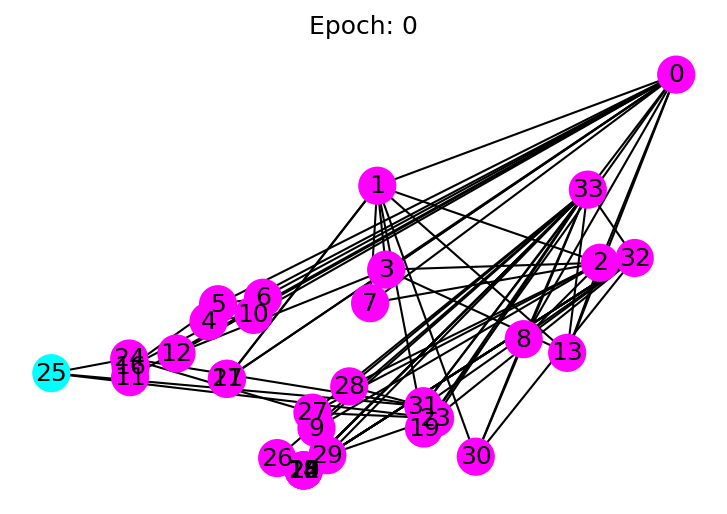

In [25]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
%matplotlib inline
def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors,
            with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(0)  # draw the prediction of the first epoch
# plt.close()

/Users/ogata2/.pyenv/versions/3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


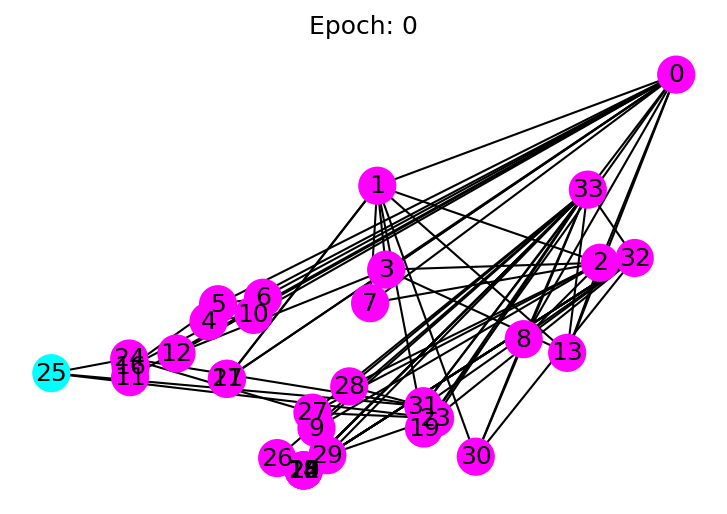

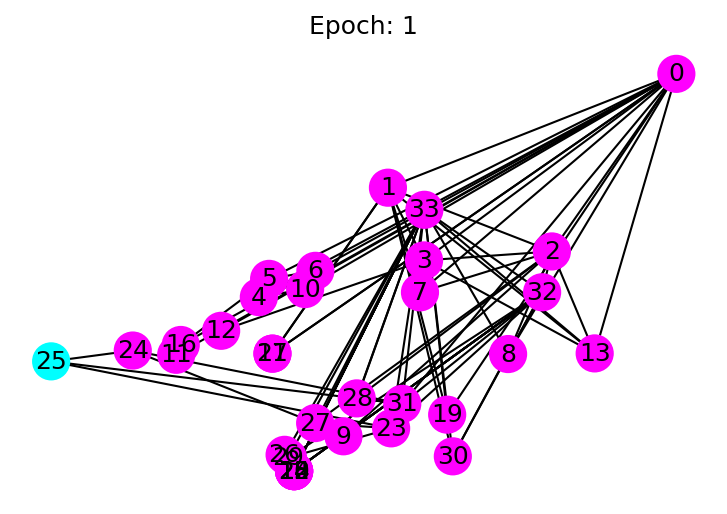

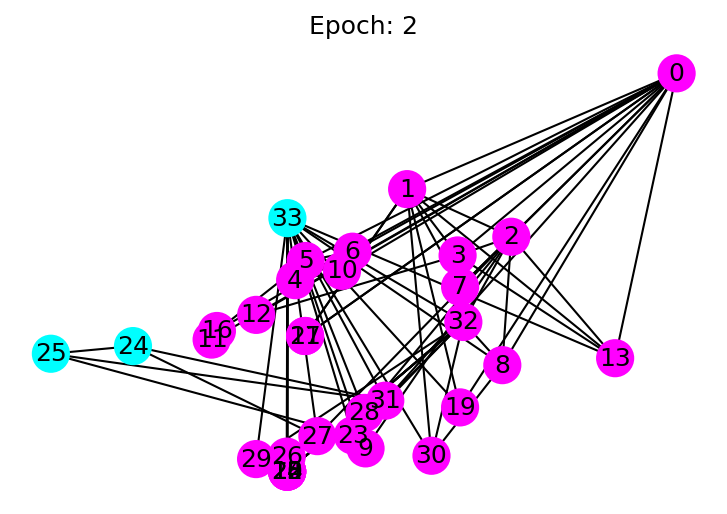

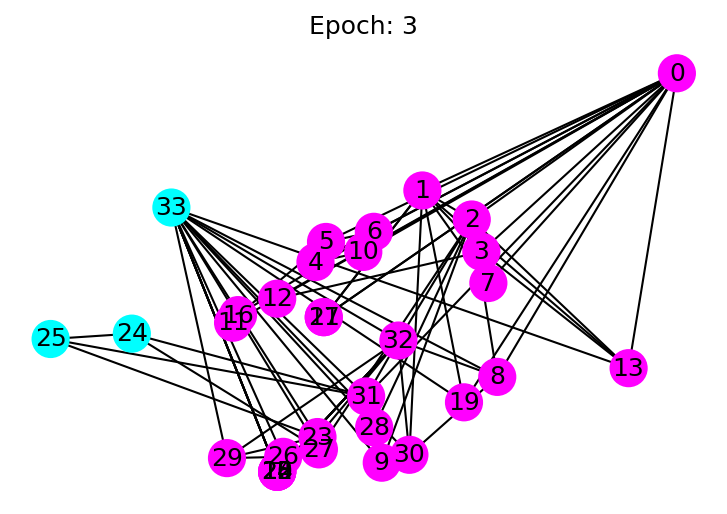

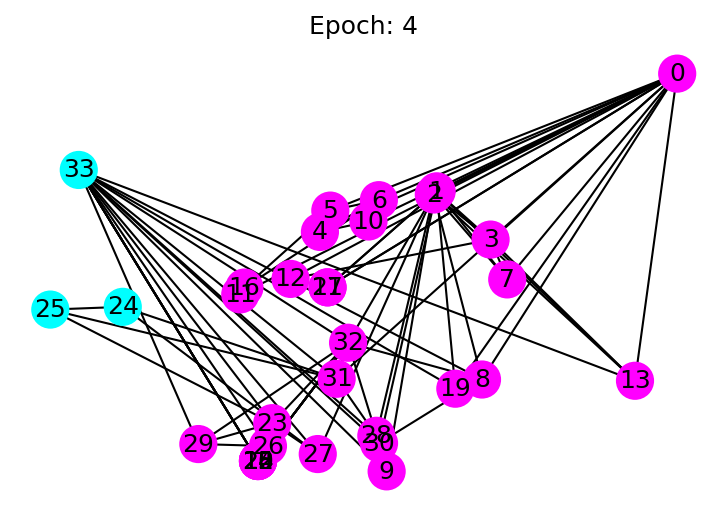

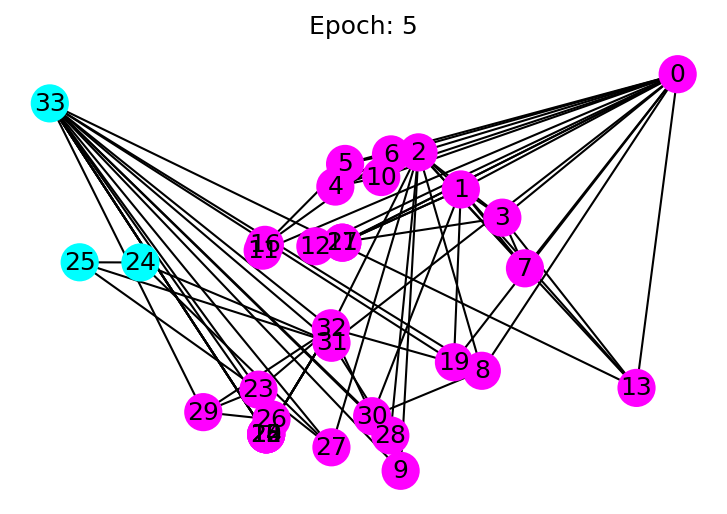

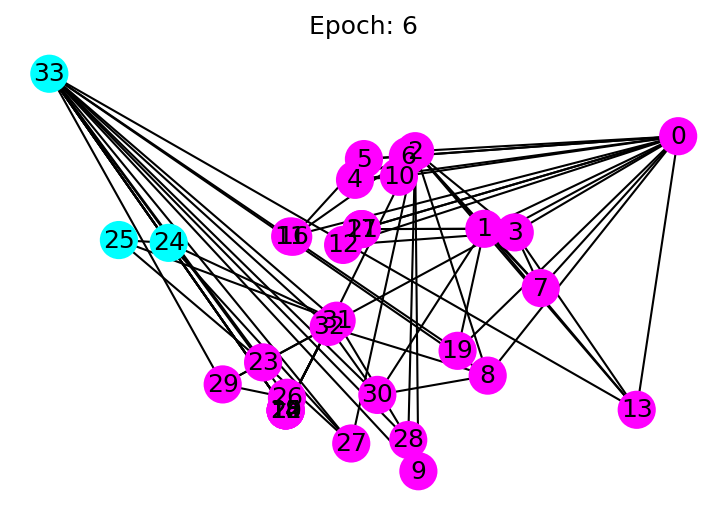

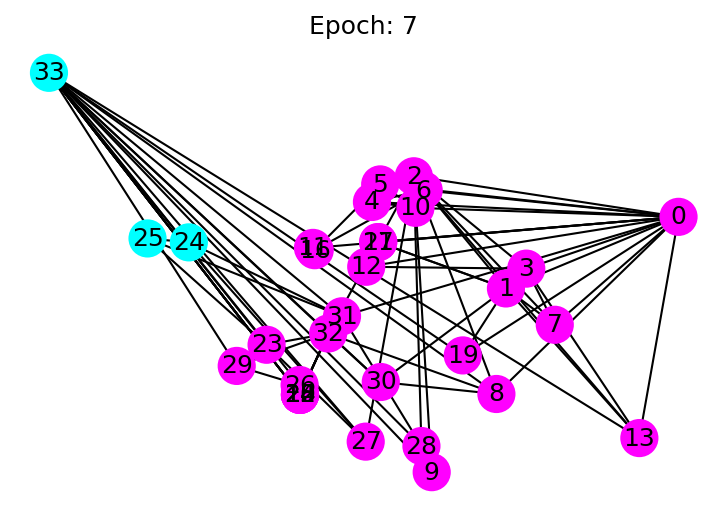

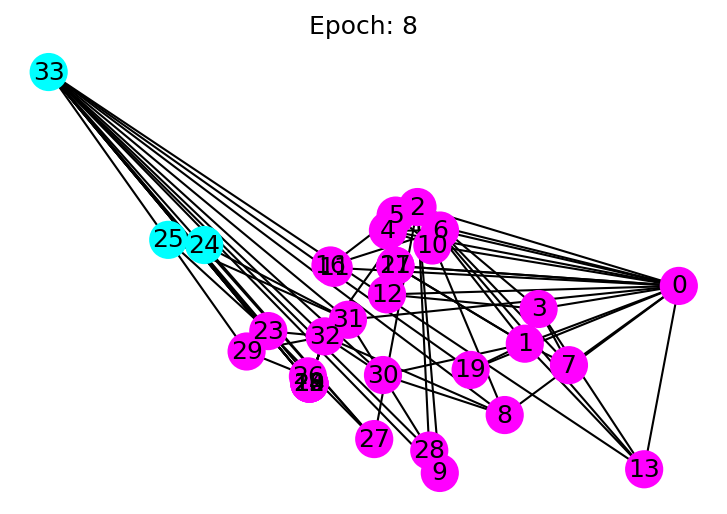

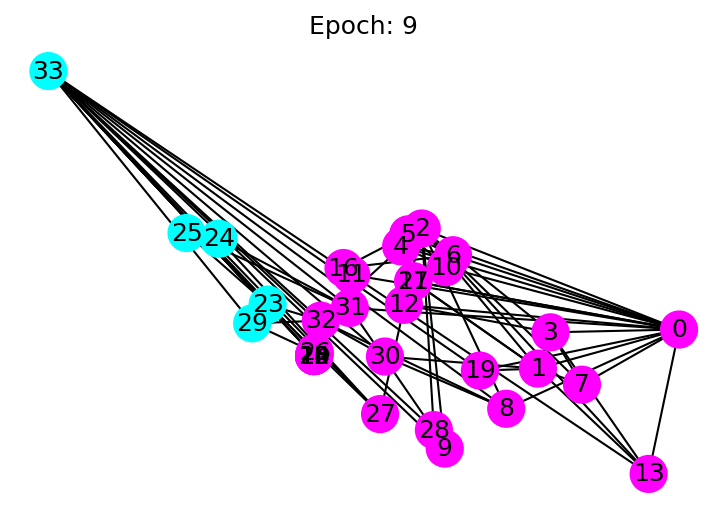

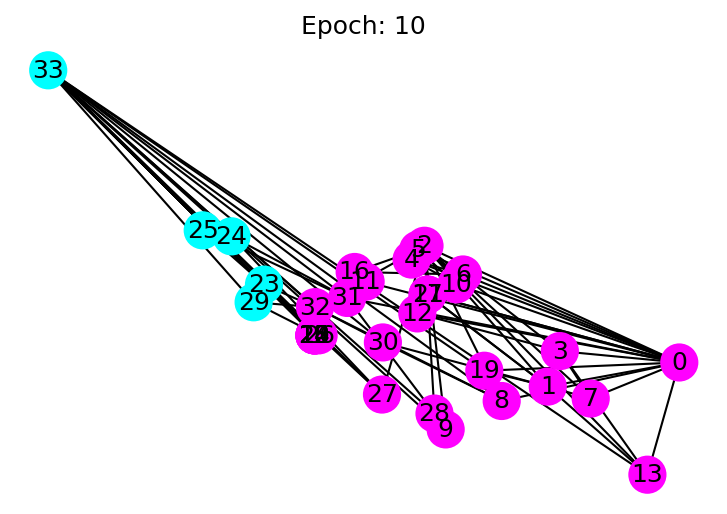

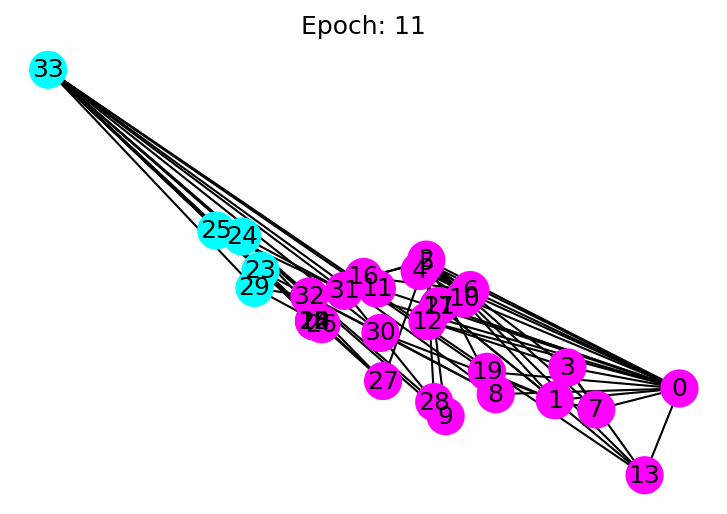

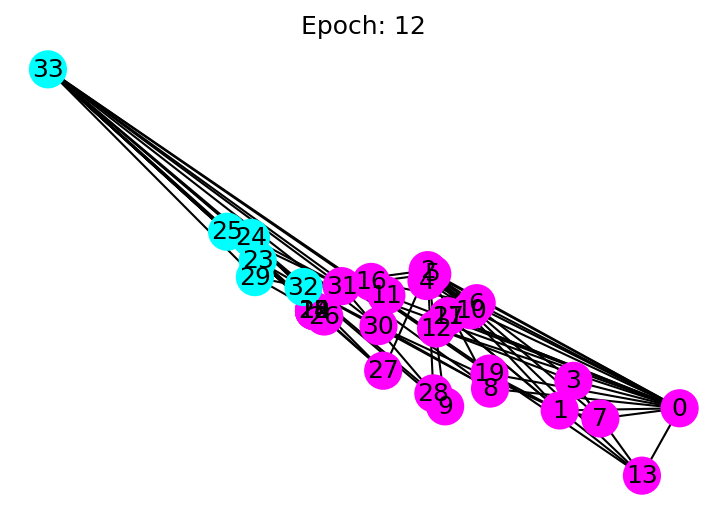

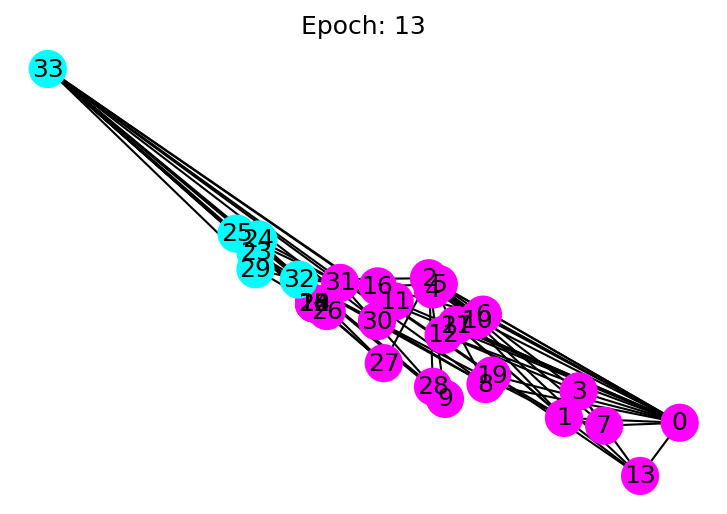

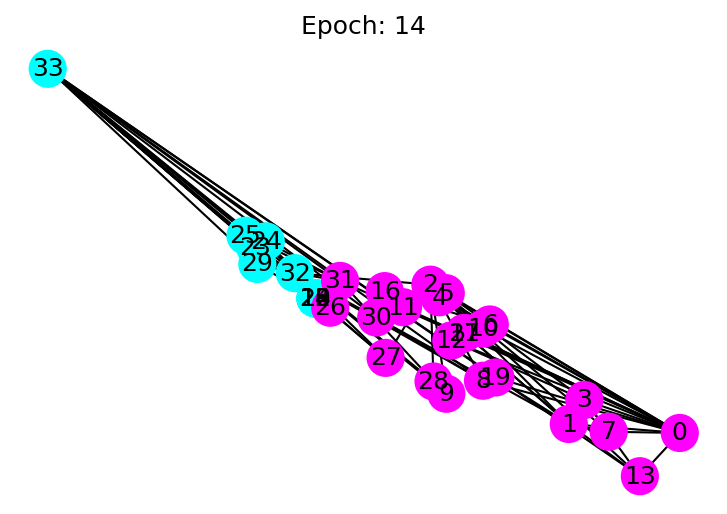

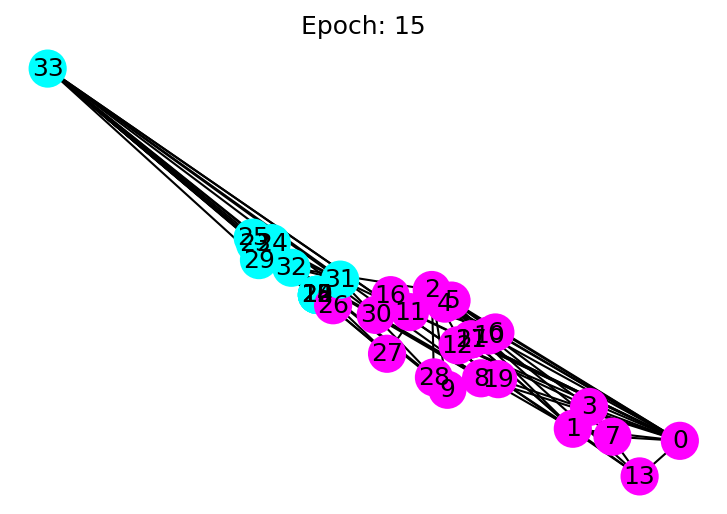

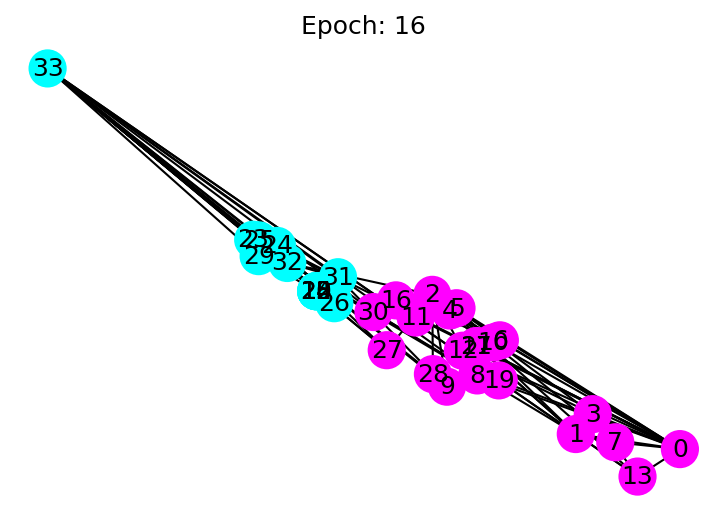

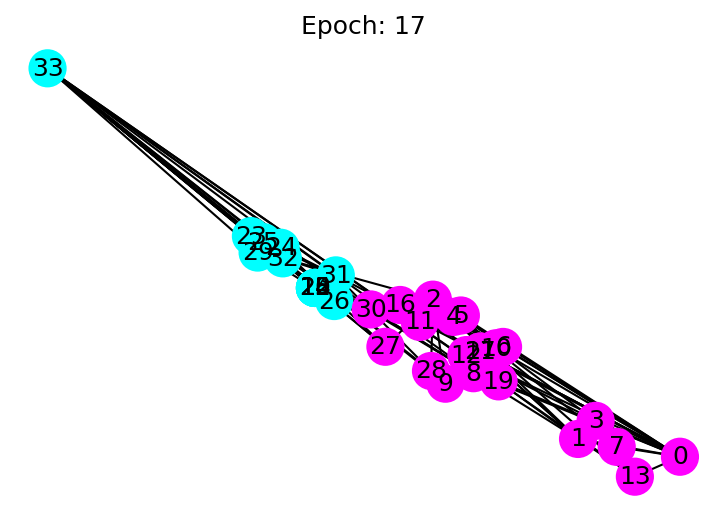

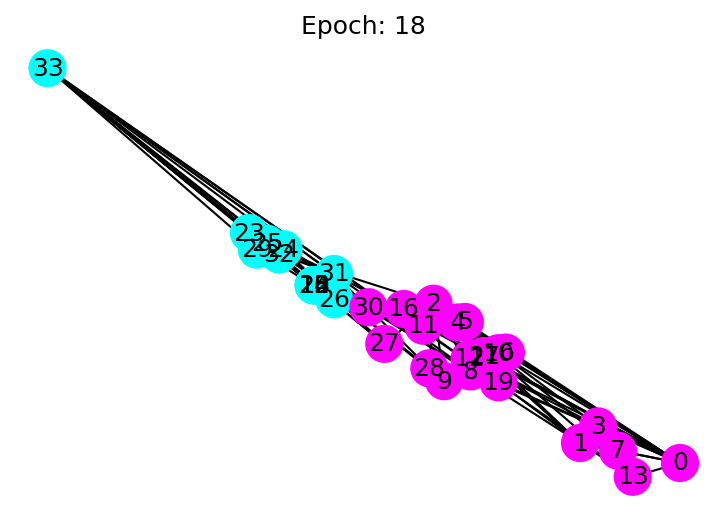

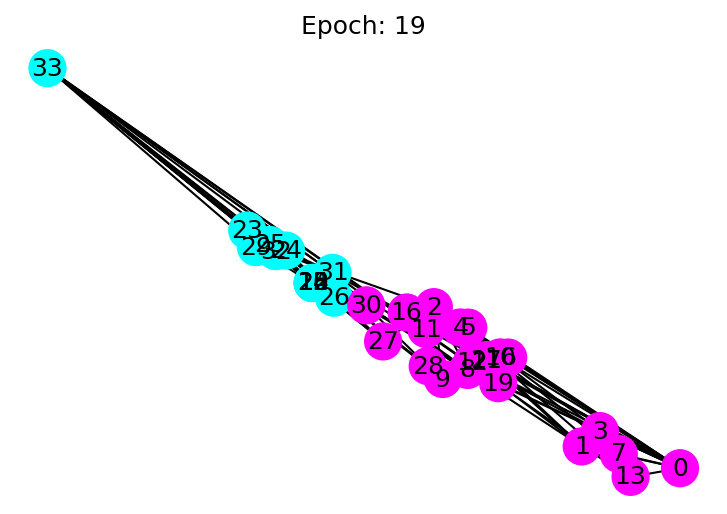

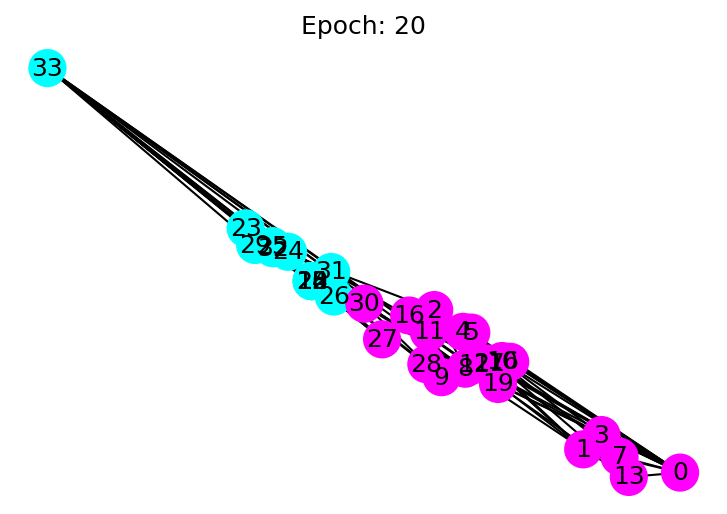

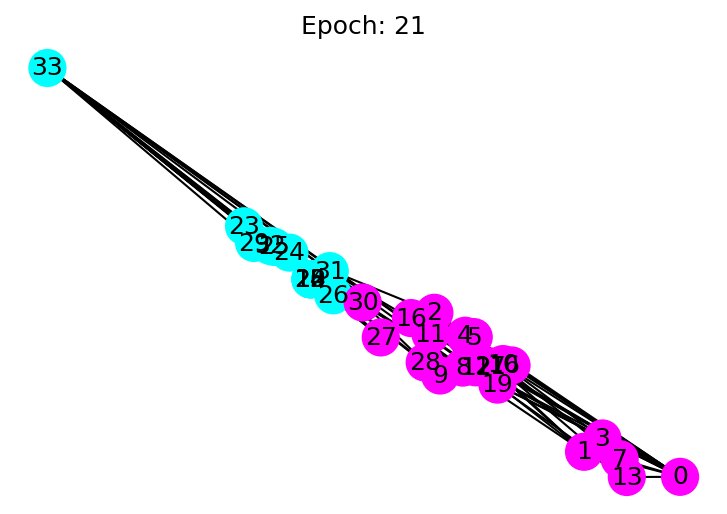

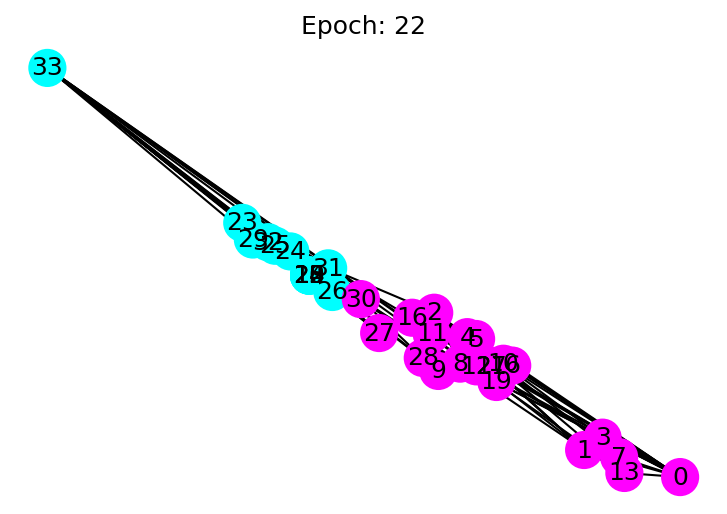

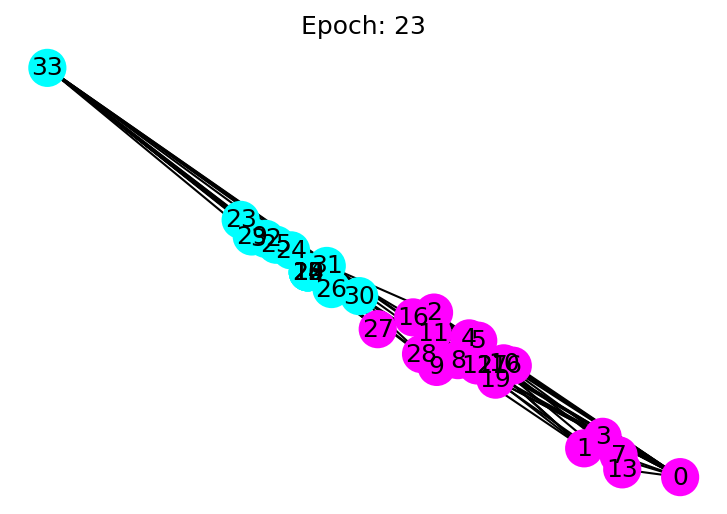

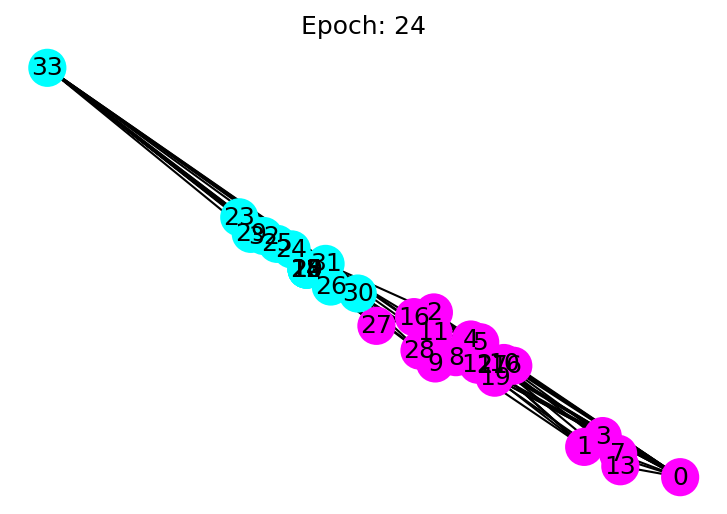

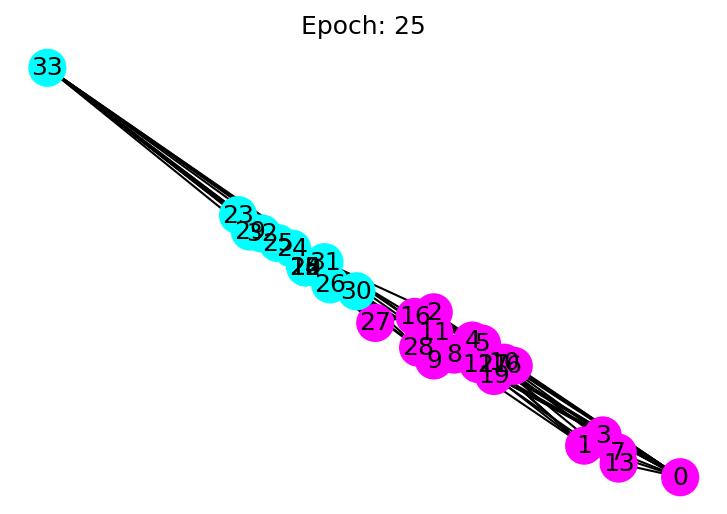

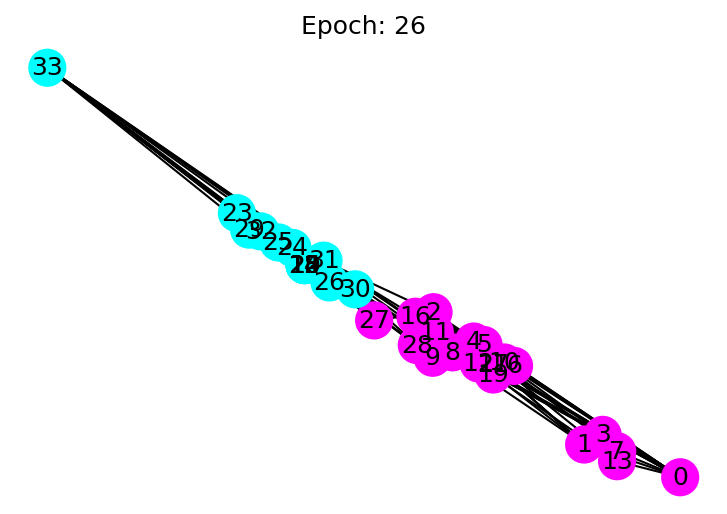

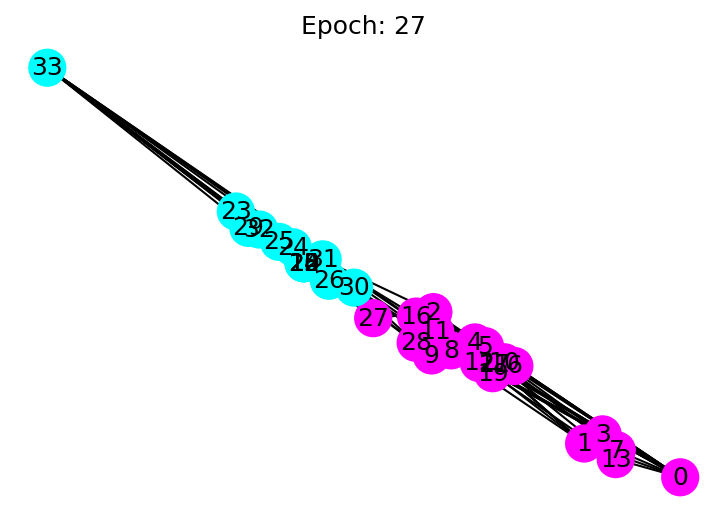

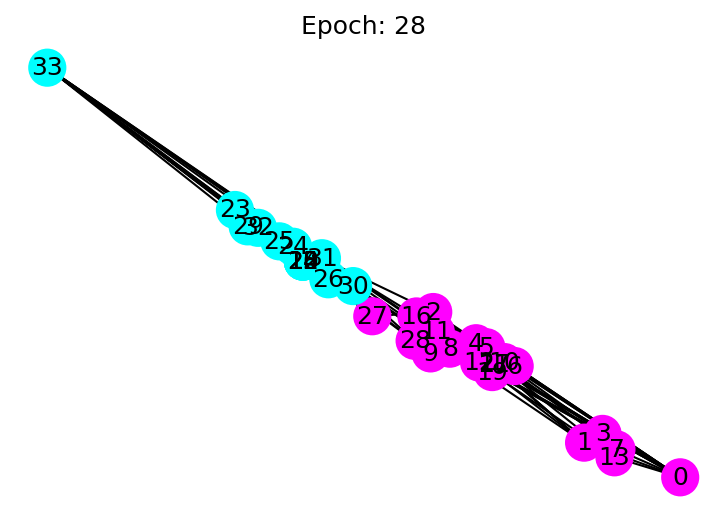

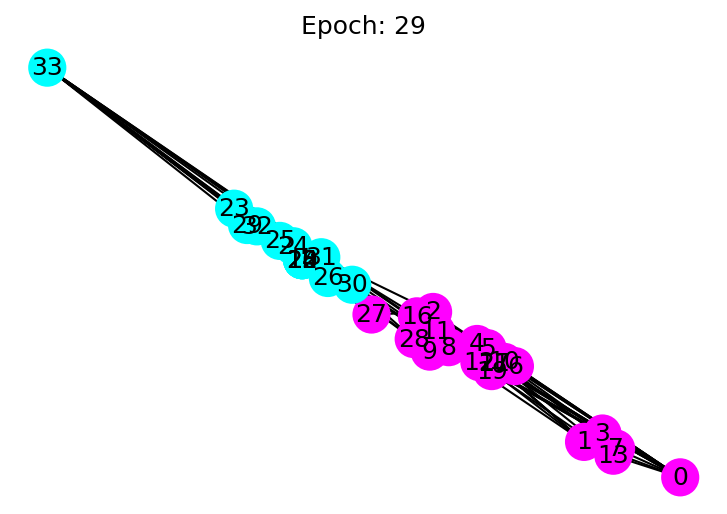

In [26]:
for i in range(30):
    fig = plt.figure(dpi=150)
    fig.clf()
    ax = fig.subplots()
    draw(i)

In [24]:
ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)

# ひと目でわかるDGL2

# DGL Tutorials : Basics : DGL 基本
このチュートリアルの目標は :

- グラフを作成する。
- ノードとエッジ表現を読み書きする。
 

## グラフ作成
DGLGraph の設計は他のグラフ・ライブラリの影響を受けています。実際に、networkx からグラフを作成してそれを DGLGraph に変換することができます、逆もまた同様です :

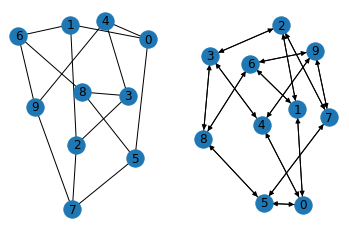

In [27]:
import networkx as nx
import dgl

g_nx = nx.petersen_graph()
g_dgl = dgl.DGLGraph(g_nx)

import matplotlib.pyplot as plt
plt.subplot(121)
nx.draw(g_nx, with_labels=True)
plt.subplot(122)
nx.draw(g_dgl.to_networkx(), with_labels=True)

plt.show()

これらは同じグラフです、DGLGraph が常に有向であることを除いて。

DGL 自身のインターフェイスを呼び出すことによりグラフを作成することもできます。

今はスターグラフを構築しましょう。DGLGraph ノードは 0 から number_of_nodes() の整数の連続する範囲で add_nodes を呼び出すことで拡大できます。DGLGraph エッジはそれらの追加の順序にあります。エッジはノードと大体同じ方法でアクセスされることに注意してください、エッジ・ブロードキャスティングの一つの特別な特徴を除いて :

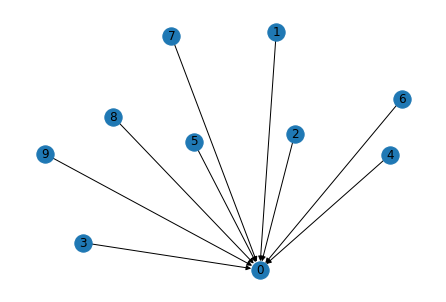

In [84]:
import dgl
import torch as th

g = dgl.DGLGraph()
g.add_nodes(10)
# a couple edges one-by-one
for i in range(1, 5):
    g.add_edge(i, 0)
# a few more with a paired list
src = list(range(5, 8)); dst = [0]*3
g.add_edges(src, dst)
# finish with a pair of tensors
src = th.tensor([8, 9]); dst = th.tensor([0, 0])
g.add_edges(src, dst)

# edge broadcasting will do star graph in one go!
g.clear(); g.add_nodes(10)
src = th.tensor(list(range(1, 10)));
g.add_edges(src, 0)

import networkx as nx
import matplotlib.pyplot as plt
nx.draw(g.to_networkx(), with_labels=True)
plt.show()

In [85]:
# src

## 特徴割り当て
DGLGraph のノードとエッジに特徴を割り当てることもできます。特徴は、フィールドと呼ばれる、名前 (文字列) と tensor の辞書として表わされます。

次のコードスニペットは各ノードにベクトル (len=3) を割り当てます。

In [86]:
import dgl
import torch as th
# g.clear()
x = th.randn(10, 3)
g.ndata['x'] = x

In [87]:
# g.nodes[:].data['x']

ndata は総てのノードのステートにアクセスするためのシンタックスシュガーで、ステートはユーザ定義辞書にとどまるコンテナ・データにストアされます。

In [88]:
print(g.ndata['x'] == g.nodes[:].data['x'])

# access node set with integer, list, or integer tensor
g.nodes[0].data['x'] = th.zeros(1, 3)
g.nodes[[0, 1, 2]].data['x'] = th.zeros(3, 3)
g.nodes[th.tensor([0, 1, 2])].data['x'] = th.zeros(3, 3)

tensor([[True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True]])


エッジ特徴の割り当てはノード特徴のそれに類似の流儀です、エッジのエンドポイントを指定することによってもそれを行えることを除いて。

In [89]:
g.ndata

{'x': tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.7947,  1.4124, -0.3559],
        [ 1.9769, -1.2148,  1.0809],
        [-1.3175, -0.6104,  0.9585],
        [ 1.8911,  1.0996,  1.6645],
        [-1.5743,  0.0568, -0.4812],
        [ 0.8964,  2.5026, -0.5695],
        [-0.8687, -1.1760,  0.4939]])}

In [90]:
g.edata['w'] = th.randn(9, 2)

# access edge set with IDs in integer, list, or integer tensor
g.edges[1].data['w'] = th.randn(1, 2)
g.edges[[0, 1, 2]].data['w'] = th.zeros(3, 2)
g.edges[th.tensor([0, 1, 2])].data['w'] = th.zeros(3, 2)

# one can also access the edges by giving endpoints
g.edges[1, 0].data['w'] = th.ones(1, 2)                 # edge 1 -> 0
g.edges[[1, 2, 3], [0, 0, 0]].data['w'] = th.ones(3, 2) # edges [1, 2, 3] -> 0

In [91]:
g.edata["w"]

tensor([[ 1.0000,  1.0000],
        [ 1.0000,  1.0000],
        [ 1.0000,  1.0000],
        [ 0.4443, -1.2456],
        [-0.3207, -1.5577],
        [-0.7820,  2.0926],
        [ 1.0239,  0.4541],
        [-0.9340,  1.0548],
        [-0.1726,  0.1620]])

割り当ての後、各ノード/エッジ・フィールドはそのフィールド値の shape とデータ型 (dtype) を含むスキームと関連付けられます。

In [93]:
print(g.node_attr_schemes())
g.ndata['x'] = th.zeros((10, 4))
print(g.node_attr_schemes())

{'x': Scheme(shape=(3,), dtype=torch.float32)}
{'x': Scheme(shape=(4,), dtype=torch.float32)}


In [94]:
g.ndata.pop('x')
g.edata.pop('w')

tensor([[ 1.0000,  1.0000],
        [ 1.0000,  1.0000],
        [ 1.0000,  1.0000],
        [ 0.4443, -1.2456],
        [-0.3207, -1.5577],
        [-0.7820,  2.0926],
        [ 1.0239,  0.4541],
        [-0.9340,  1.0548],
        [-0.1726,  0.1620]])

## 多重グラフ
多くのグラフ・アプリケーションは多重エッジを必要とします。これを可能にするために、DGLGraph を multigraph=True で構築します。

In [96]:
g_multi = dgl.DGLGraph(multigraph=True)
g_multi.add_nodes(10)
g_multi.ndata['x'] = th.randn(10, 2)

g_multi.add_edges(list(range(1, 10)), 0)
g_multi.add_edge(1, 0) # two edges on 1->0

g_multi.edata['w'] = th.randn(10, 2)
g_multi.edges[1].data['w'] = th.zeros(1, 2)
print(g_multi.edges())

(tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 1]), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))


/Users/ogata2/.pyenv/versions/3.7.5/lib/python3.7/site-packages/dgl/base.py:25: UserWarning: multigraph will be deprecated.DGL will treat all graphs as multigraph in the future.
  warnings.warn(msg, warn_type)


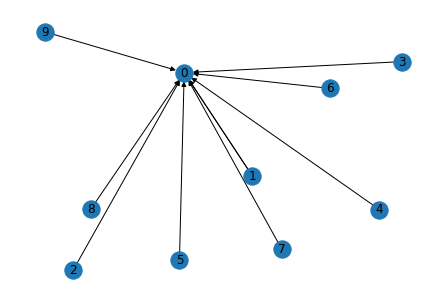

In [97]:
nx.draw(g_multi.to_networkx(), with_labels=True)
plt.show()

多重グラフのエッジはその接続ノード u と v を使用して一意に識別できません ; エッジ id を問い合わせるには edge_id インターフェイスを使用します。

In [57]:
eid_10 = g_multi.edge_id(1, 0,return_array=True)
g_multi.edges[eid_10].data['w'] = th.ones(len(eid_10), 2)
print(g_multi.edata['w'])

tensor([[ 1.0000,  1.0000],
        [ 0.0000,  0.0000],
        [-1.4133,  1.6125],
        [-0.2678, -0.4120],
        [ 1.3994, -1.1202],
        [-0.1318, -0.5703],
        [-0.2490, -1.5488],
        [-1.7131,  1.1802],
        [ 0.2951,  0.0237],
        [ 1.0000,  1.0000]])


# DGL Tutorials : Basics : DGL メッセージパッシングによるページランク
ページランクの各反復 (= iteration) で、総てのノード (web ページ) は最初にそのページランク値をその下流ノードに一様に散布します。各ノードの新しいページランク値はその近傍から受け取ったページランク値を収集することにより計算され、それからそれはダンピング因子で調整されます。

$PV(u)=\frac{1−d}{N}+d×\sum_{\in N(u)} \frac{PV(v)}{D(v)}$

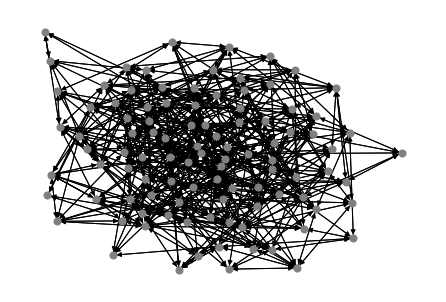

In [98]:
import networkx as nx
import matplotlib.pyplot as plt
import torch
import dgl

N = 100  # number of nodes
DAMP = 0.85  # damping factor
K = 10  # number of iterations
g = nx.nx.erdos_renyi_graph(N, 0.1)
g = dgl.DGLGraph(g)
nx.draw(g.to_networkx(), node_size=50, node_color=[[.5, .5, .5,]])
plt.show()

アルゴリズムに従えば、ページランクは典型的な scatter-gather パターンの 2 つの段階から成ります。最初に各ノードのページランク値を $1/N$ に初期化して各ノードの出次数をノード特徴としてストアします :

In [99]:
g.ndata['pv'] = torch.ones(N) / N
g.ndata['deg'] = g.out_degrees(g.nodes()).float()

それからメッセージ関数を定義します、これは総てのノードのページランク値をその出次数で除算して結果をメッセージとしてその近傍に渡します :

In [101]:
def pagerank_message_func(edges):
    return {'pv' : edges.src['pv'] / edges.src['deg']}

DGL では、メッセージ関数は エッジ UDF として表わされます。エッジ UDF は単一の引数 edges を取ります。それは送信元ノード特徴、送信先ノード特徴とエッジ特徴のそれぞれにアクセスするために 3 つのメンバー src, dst と data を持ちます。ここで、この関数は送信元特徴だけからのメッセージを計算します。

次に、reduce 関数を定義します、これはその mailbox からのメッセージを除去して収集して、そしてその新しいページランク値を計算します :

In [102]:
def pagerank_reduce_func(nodes):
    msgs = torch.sum(nodes.mailbox['pv'], dim=1)
    pv = (1 - DAMP) / N + DAMP * msgs
    return {'pv' : pv}

message 関数と reduce 関数を登録します、これらは後で DGL により呼び出されます。

In [104]:
g.register_message_func(pagerank_message_func)
g.register_reduce_func(pagerank_reduce_func)

そしてアルゴリズムは非常に率直です。ここに一つの PageRank iteration のためのコードがあります :

In [106]:
def pagerank_naive(g):
    # Phase #1: send out messages along all edges.
    for u, v in zip(*g.edges()):
        g.send((u, v))
    # Phase #2: receive messages to compute new PageRank values.
    for v in g.nodes():
        g.recv(v)

## バッチ処理セマンティクスによる改良
上のコードは巨大なグラフにスケールしません、何故ならばそれは総てのノードに渡り iterate するからです。DGL はユーザにノードやエッジのバッチ上で計算させることでこれを解決します。例えば、次のコードは複数ノードとエッジ上で message と reduce 関数を一度に起動します。

In [107]:
def pagerank_batch(g):
    g.send(g.edges())
    g.recv(g.nodes())

私達は依然として同じ reduce 関数 pagerank_reduce_func を使用していることに注意してください、そこでは nodes.mailbox[‘pv’] は単一の tensor で、incoming メッセージを 2 番目の次元に沿ってスタックします。

自然に、総てのノードで並列に reduce を遂行することさえも可能であるか疑問に思うでしょう、何故ならば各ノードは異なる数の incoming メッセージを持つかもしれず、そして異なる長さの tensor を実際には一緒に「スタック」できないからです。一般に、DGL は incoming メッセージの数によりノードをグループ分けして各グループに対して reduce 関数を呼び出すことにより問題を解決します。

 

# 高位 API による更なる改良
基本的な send と recv を様々な方法で結合する多くのルーチンを提供します。それらは レベル-2 API と呼称されます。例えば、ページランク・サンプルは次のように更に単純化されます :

In [108]:
def pagerank_level2(g):
    g.update_all()

update_all の他にも、このレベル-2 カテゴリーで pull, push と send_and_recv もまた持ちます。より詳細については API リファレンス を参照してください。

## GL 組み込み関数でより多くの改良
message と reduce 関数の幾つかは非常に共通に使用されますので、DGL はまた組み込み関数も提供します。例えば、2 つの組み込み関数がページランク・サンプルで使用できます。

- dgl.function.copy_src(src, out) はエッジ UDF で送信元ノード特徴データを使用して出力を計算します。ユーザは送信元特徴データの名前 (src) と出力名 (out) を指定する必要があります。
- dgl.function.sum(msg, out) はノード UDF でノードの mailbox のメッセージを合計します。ユーザはメッセージ名 (msg) と出力名 (out) を指定する必要があります。

例えば、ページランク・サンプルは次のように書き換えることができます :

In [109]:
import dgl.function as fn

def pagerank_builtin(g):
    g.ndata['pv'] = g.ndata['pv'] / g.ndata['deg']
    g.update_all(message_func=fn.copy_src(src='pv', out='m'),
                 reduce_func=fn.sum(msg='m',out='m_sum'))
    g.ndata['pv'] = (1 - DAMP) / N + DAMP * g.ndata['m_sum']

In [111]:
K=10
for k in range(K):
    # Uncomment the corresponding line to select different version.
    # pagerank_naive(g)
    # pagerank_batch(g)
    # pagerank_level2(g)
    pagerank_builtin(g)
print(g.ndata['pv'])

tensor([0.0131, 0.0091, 0.0102, 0.0093, 0.0107, 0.0069, 0.0092, 0.0074, 0.0116,
        0.0082, 0.0099, 0.0077, 0.0093, 0.0083, 0.0109, 0.0116, 0.0084, 0.0100,
        0.0099, 0.0116, 0.0074, 0.0176, 0.0084, 0.0093, 0.0049, 0.0092, 0.0050,
        0.0101, 0.0093, 0.0108, 0.0099, 0.0128, 0.0058, 0.0135, 0.0076, 0.0133,
        0.0066, 0.0075, 0.0075, 0.0103, 0.0107, 0.0107, 0.0124, 0.0076, 0.0092,
        0.0126, 0.0126, 0.0095, 0.0101, 0.0137, 0.0100, 0.0100, 0.0102, 0.0075,
        0.0127, 0.0126, 0.0116, 0.0076, 0.0077, 0.0075, 0.0116, 0.0125, 0.0059,
        0.0099, 0.0084, 0.0067, 0.0061, 0.0108, 0.0076, 0.0134, 0.0084, 0.0095,
        0.0109, 0.0088, 0.0108, 0.0133, 0.0107, 0.0117, 0.0132, 0.0110, 0.0083,
        0.0142, 0.0101, 0.0092, 0.0117, 0.0126, 0.0133, 0.0098, 0.0100, 0.0087,
        0.0093, 0.0084, 0.0119, 0.0162, 0.0092, 0.0099, 0.0083, 0.0096, 0.0111,
        0.0100])


## 単純なグラフ分類タスク
このチュートリアルでは、バッチ化されたグラフ分類を dgl でどのように遂行するかを以下のような 8 タイプの標準的なグラフを分類する toy サンプルを通して学習します :

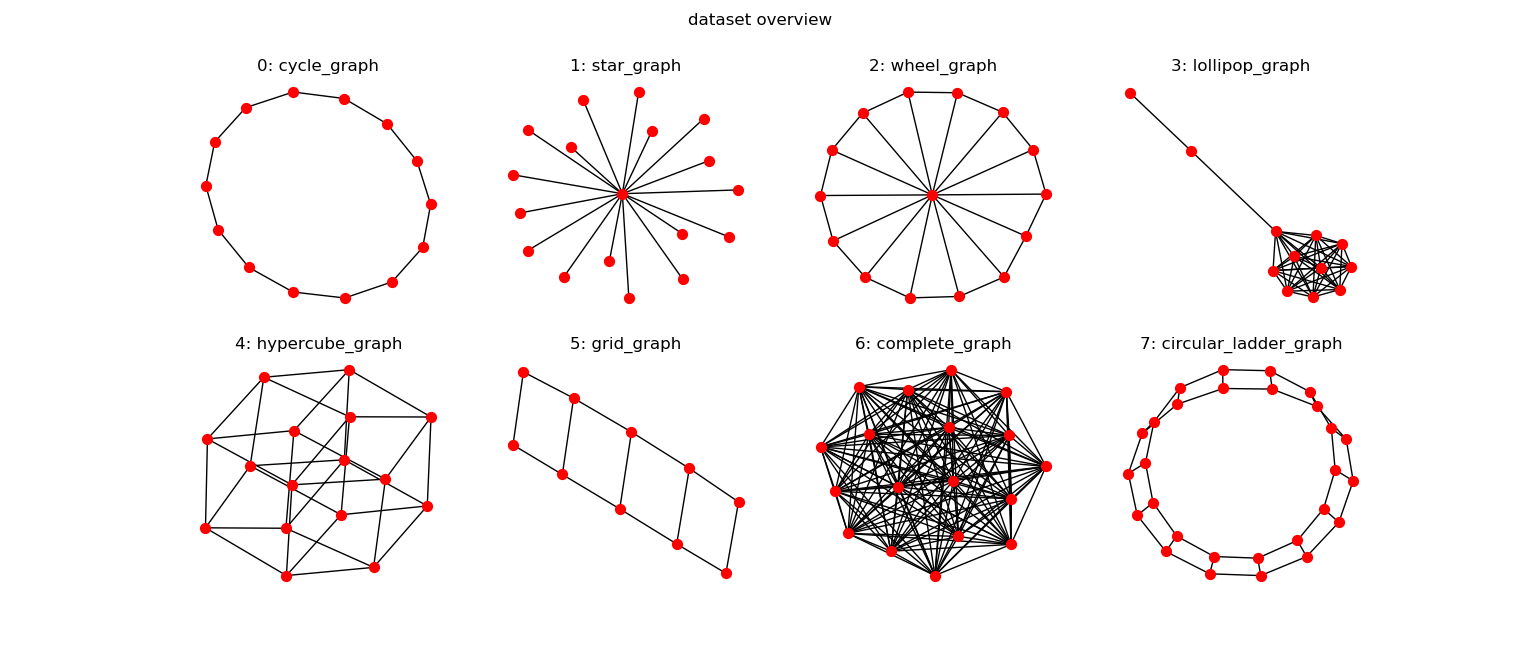

DGL で合成データセット data.MiniGCDataset を実装しています。データセットは 8 つの異なるタイプのグラフを持ちそして各クラスは同じ数のグラフサンプルを持ちます。

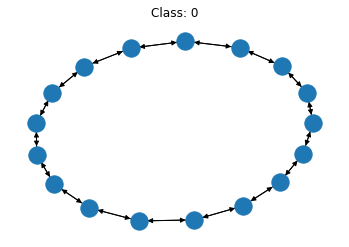

In [112]:
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx
# A dataset with 80 samples, each graph is
# of size [10, 20]
dataset = MiniGCDataset(80, 10, 20)
graph, label = dataset[0]
fig, ax = plt.subplots()
nx.draw(graph.to_networkx(), ax=ax)
ax.set_title('Class: {:d}'.format(label))
plt.show()

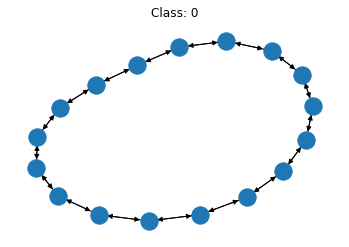

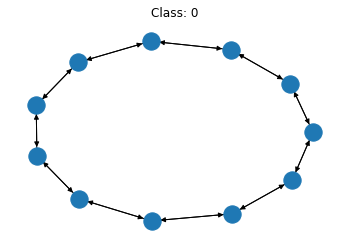

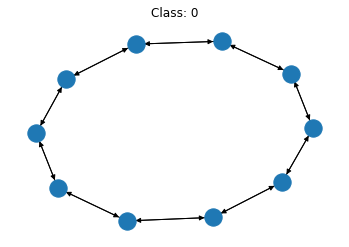

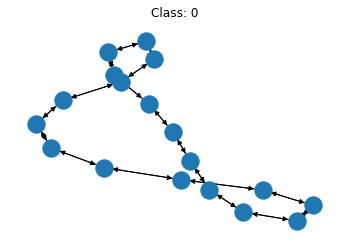

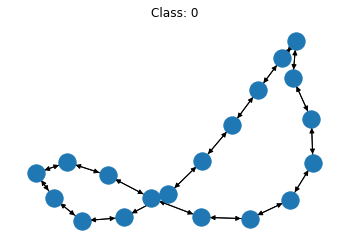

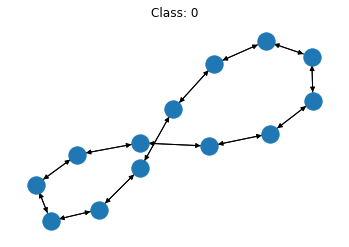

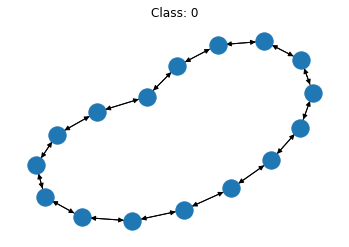

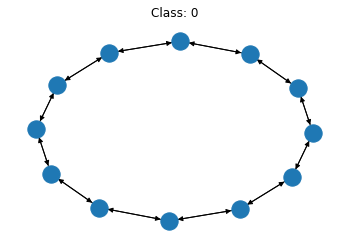

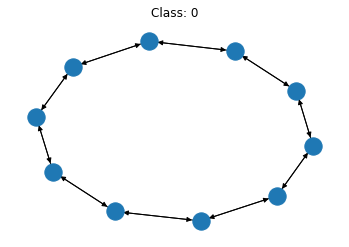

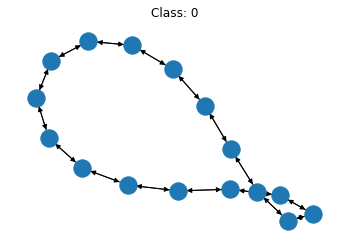

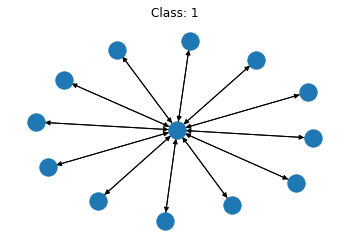

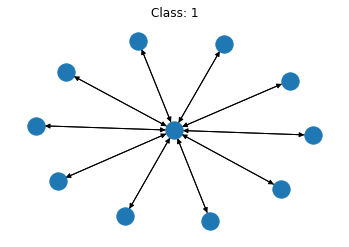

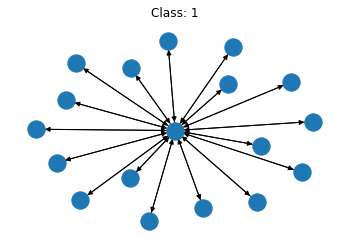

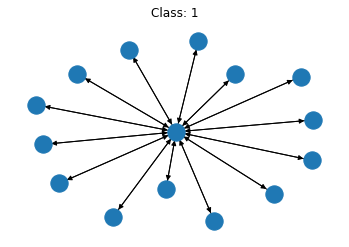

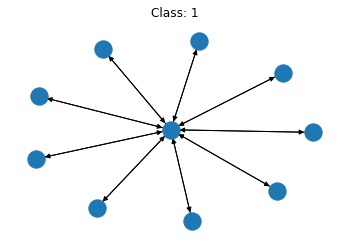

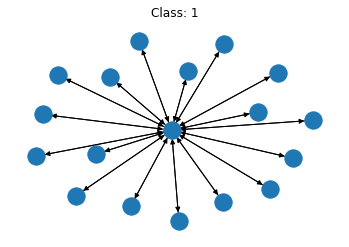

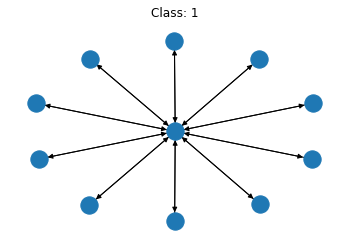

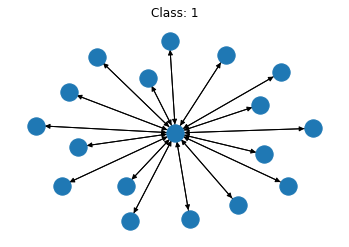

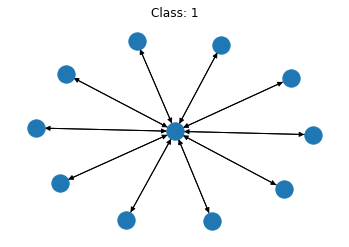

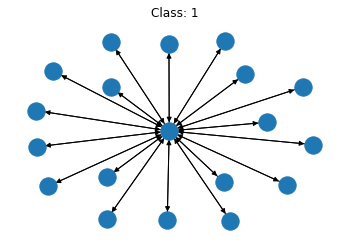

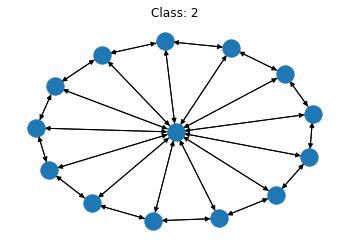

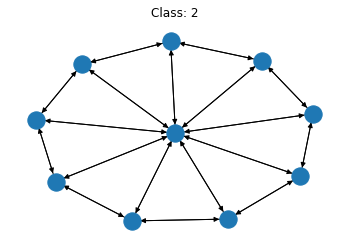

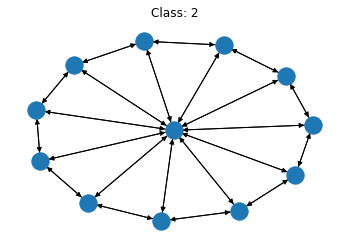

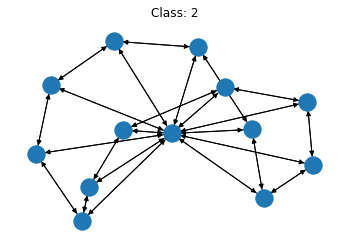

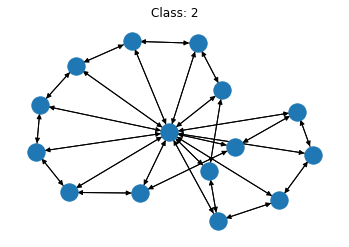

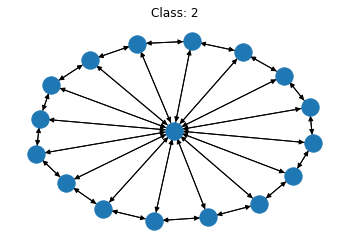

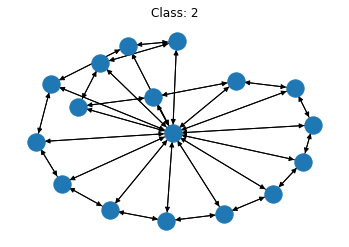

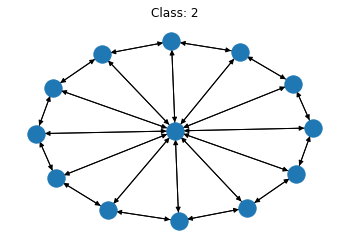

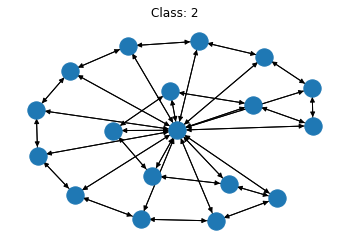

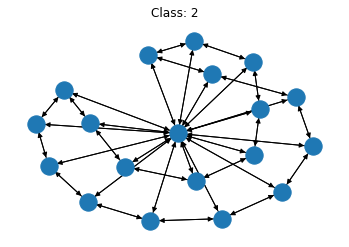

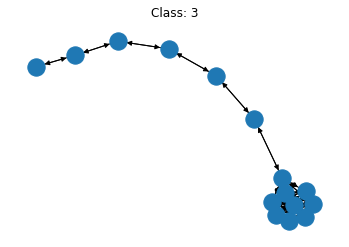

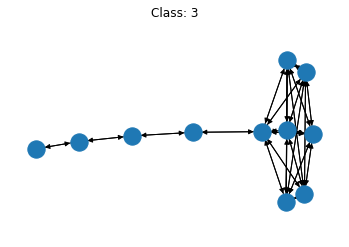

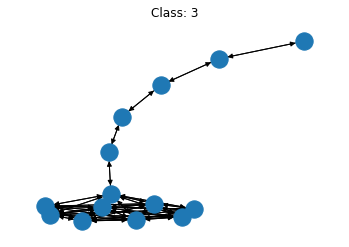

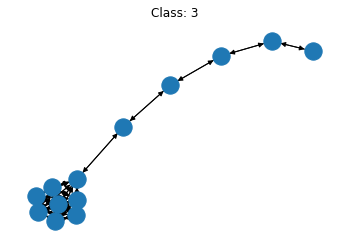

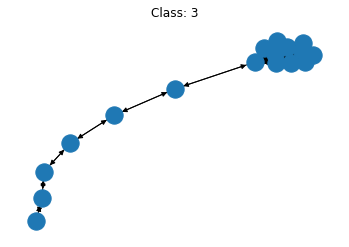

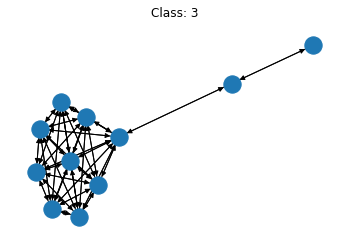

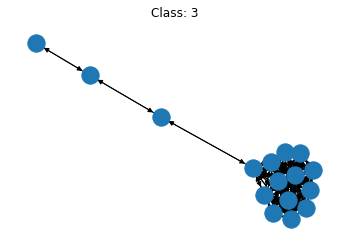

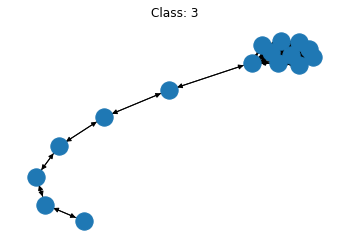

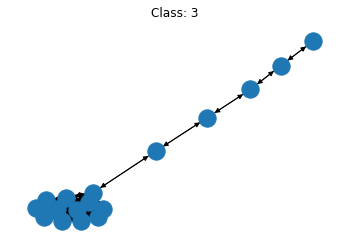

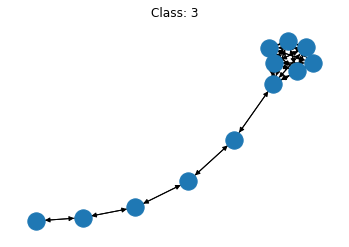

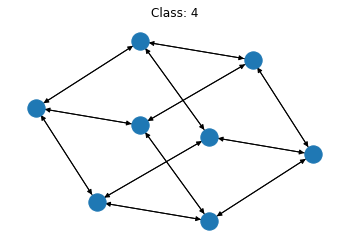

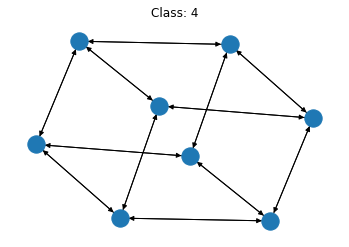

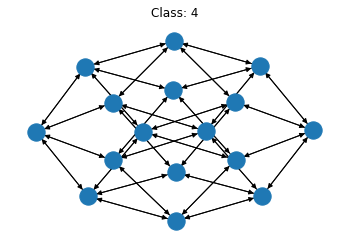

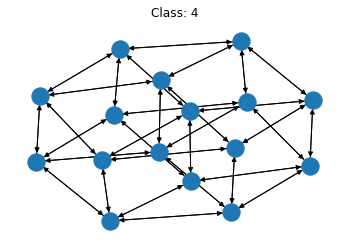

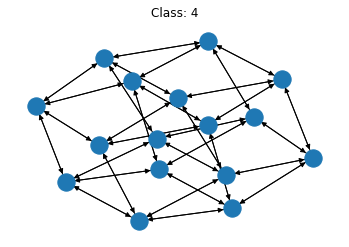

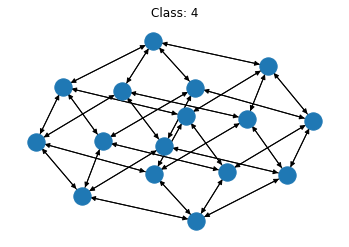

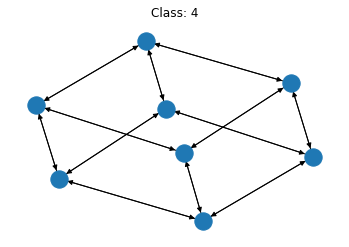

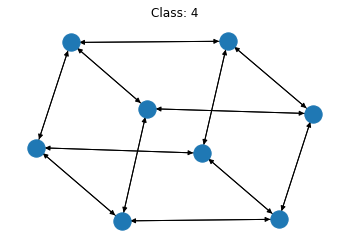

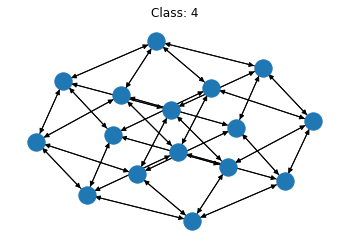

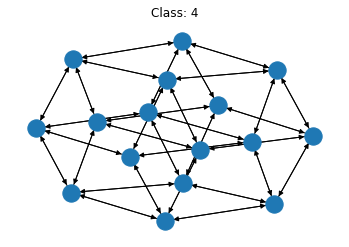

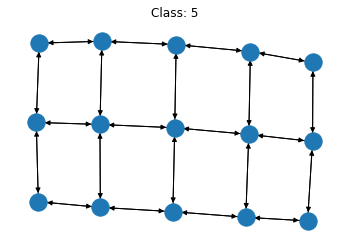

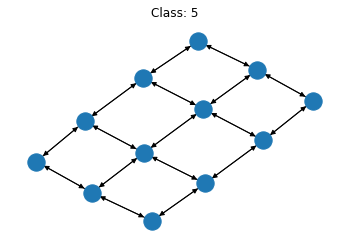

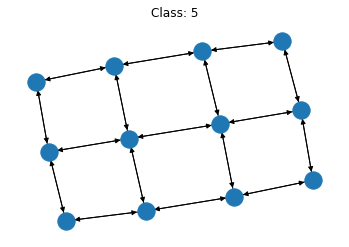

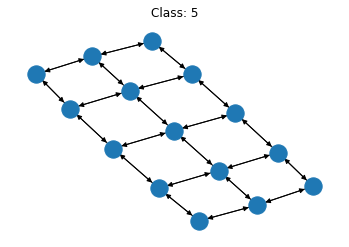

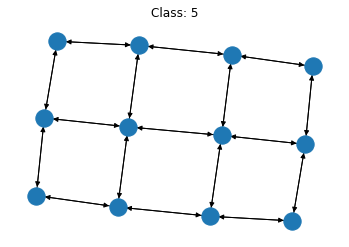

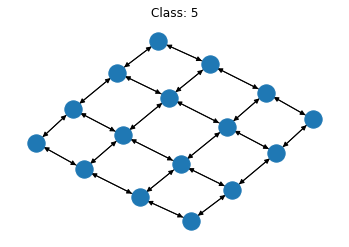

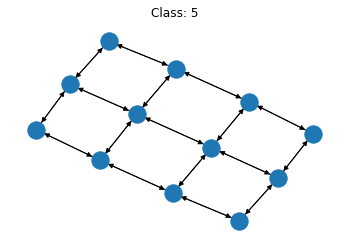

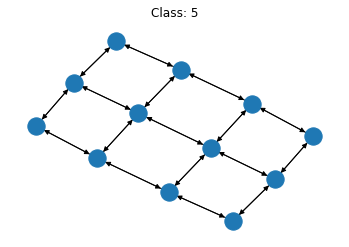

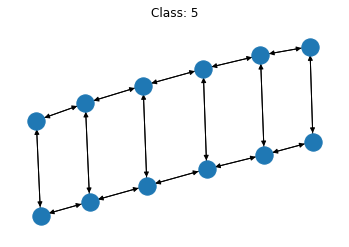

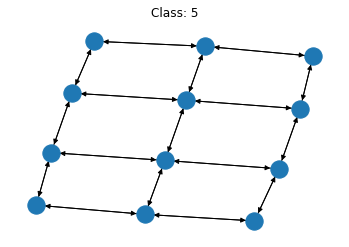

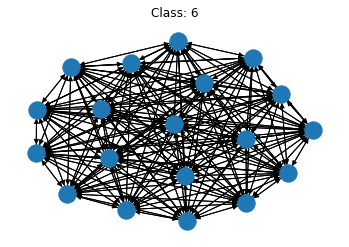

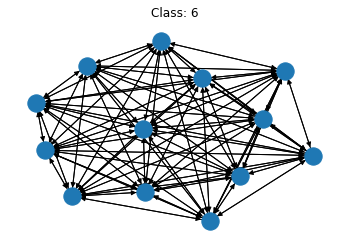

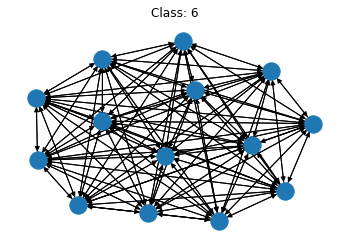

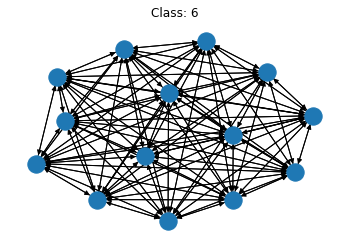

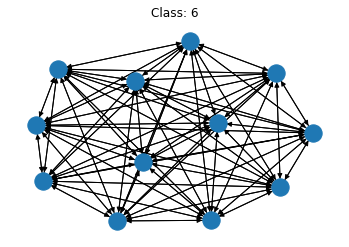

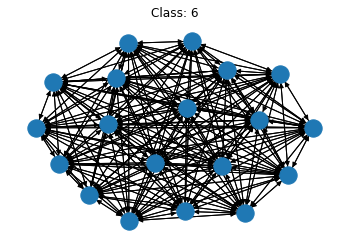

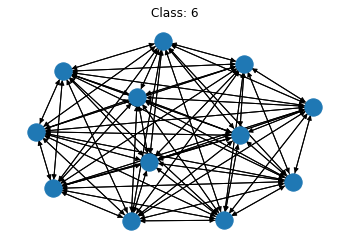

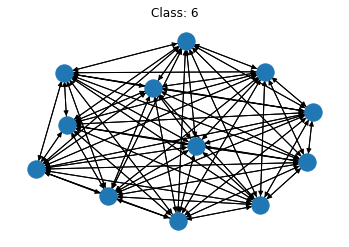

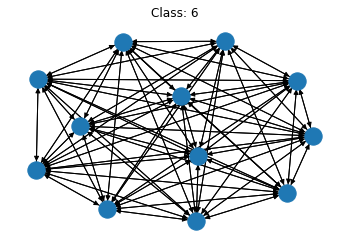

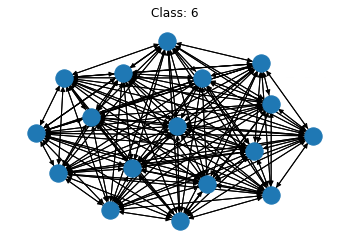

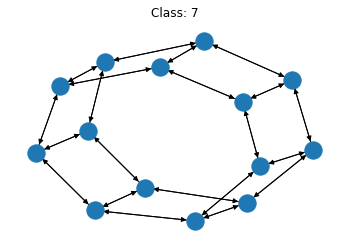

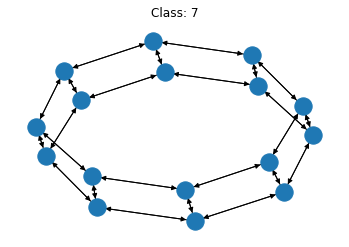

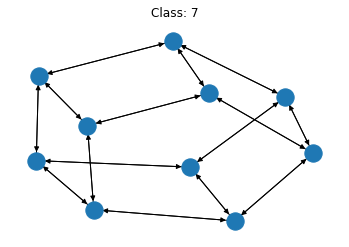

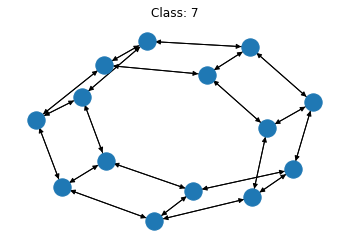

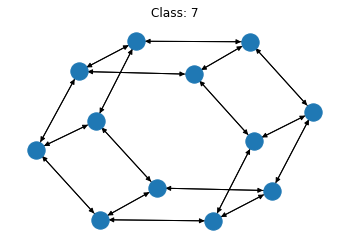

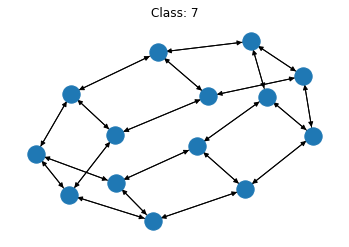

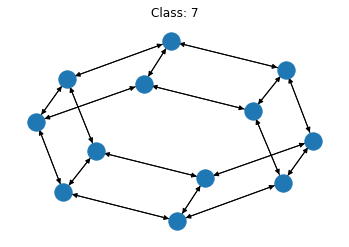

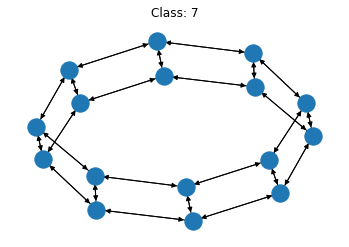

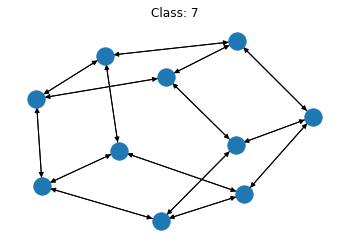

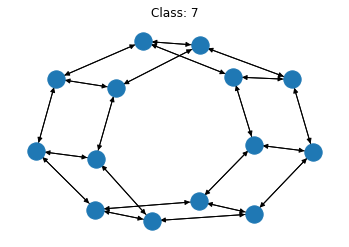

In [113]:
for i in range(80):
    graph, label = dataset[i]
    fig, ax = plt.subplots()
    nx.draw(graph.to_networkx(), ax=ax)
    ax.set_title('Class: {:d}'.format(label))
    plt.show()

グラフ・ミニバッチを構成する
ニューラルネットワークをより効率的に訓練するために、一般的な実践はミニバッチを構成するために複数のサンプルを一緒にバッチ化することです。固定された shape の tensor 入力のバッチ化は非常に容易です (例えば、サイズ 28×28 の 2 つの画像は shape 2x28x28 の shape の tensor を与えます)。対照的に、グラフ入力のバッチ化は 2 つの課題を持ちます :

グラフはスパースです。
グラフは様々な長さを持つことができます (e.g. ノードとエッジの数)。
これに対応するために、DGL は dgl.batch() API を提供します。

それはグラフのバッチが (多くの互いに素な (= disjoint) 接続された (= connected) 構成要素を持つ) 巨大なグラフとして見えるようなトリックを活用します。下は一般的なアイデアを与える可視化です :



In [116]:
import dgl

def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

dgl.batch() の戻り値の型は依然としてグラフです (tensor のバッチが依然として tensor である事実に類似しています)。これは1 つのグラフのために動作する任意のコードは直ちにグラフのバッチのために動作することを意味します。より重要なことは、DGL は総てのノードとエッジ上のメッセージを並列に処理しますので、これは効率性を大きく改良します。

## グラフ分類器

グラフ分類は次のように進めることができます :

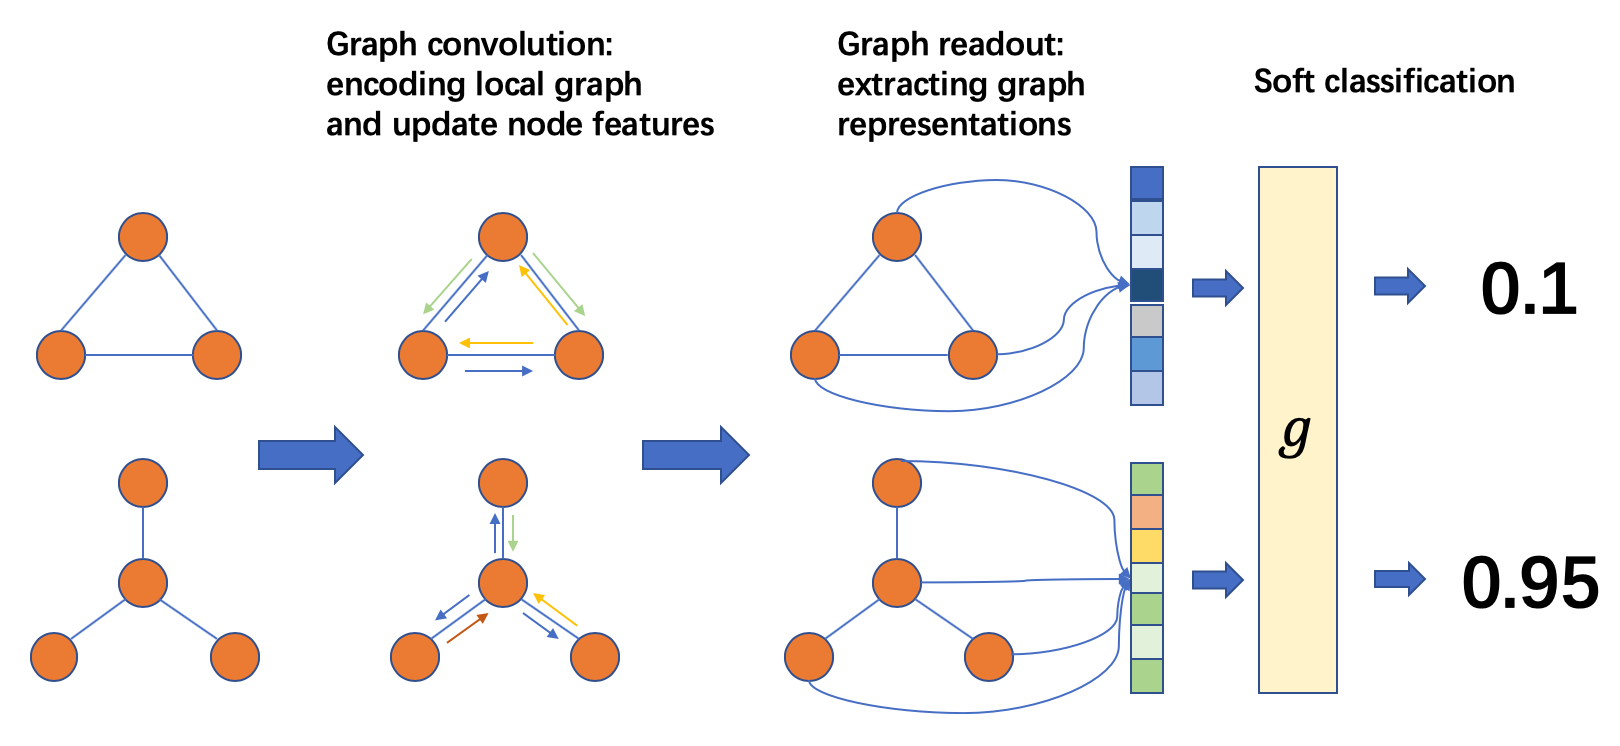

グラフのバッチから、最初にノードが他の「通信する」ためにメッセージパッシング/グラフ畳み込みを遂行します。メッセージパッシングの後、ノード (そしてエッジ) 属性からグラフ表現のための tensor を計算します。このステップは交互に “読み出し/収集 (= readout/aggregation)” と呼べるかもしれません。最後に、グラフ表現はグラフラベルを予測するために分類器$g$に供給できます。

## グラフ畳み込み

グラフ畳み込み演算は基本的には GCN のためのそれと同じです (チュートリアル を確認してください)。唯一の違いは $h(l+1)v=ReLU(b(l)+∑u∈(v)h(l)uW(l))$ を$ h^{(l+1)}_v=ReLU(b(l)+1|(v)|∑u∈N(v)h(l)uW(l)) $で置き換えることです。合計の平均による置き換えは異なる次元を持つノードのバランスを取るためで、これはこの実験のためにより良いパフォーマンスを与えます。

データセット初期化で追加される self エッジは平均を取る時に元のノード特徴 $h^l_v$ を含めることを可能にすることに注意してください。

In [117]:
import dgl.function as fn
import torch
import torch.nn as nn


# Sends a message of node feature h.
msg = fn.copy_src(src='h', out='m')

def reduce(nodes):
    """Take an average over all neighbor node features hu and use it to
    overwrite the original node feature."""
    accum = torch.mean(nodes.mailbox['m'], 1)
    return {'h': accum}

class NodeApplyModule(nn.Module):
    """Update the node feature hv with ReLU(Whv+b)."""
    def __init__(self, in_feats, out_feats, activation):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
        h = self.linear(node.data['h'])
        h = self.activation(h)
        return {'h' : h}

class GCN(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(GCN, self).__init__()
        self.apply_mod = NodeApplyModule(in_feats, out_feats, activation)

    def forward(self, g, feature):
        # Initialize the node features with h.
        g.ndata['h'] = feature
        g.update_all(msg, reduce)
        g.apply_nodes(func=self.apply_mod)
        return g.ndata.pop('h')

## 読み出しと分類
このデモのためには、初期ノード特徴をそれらの次数として考えます。グラフ畳み込みの 2 ラウンド後、バッチの各グラフのための総てのノード特徴に渡り平均することでグラフ読み出しを遂行します

DGL では、dgl.mean_nodes() は可変サイズを持つグラフのバッチのためにこのタスクを処理します。それからグラフ表現を pre-softmax ロジットを得るための一つの線形層を持つ分類器に供給します。

In [118]:
import torch.nn.functional as F


class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()

        self.layers = nn.ModuleList([
            GCN(in_dim, hidden_dim, F.relu),
            GCN(hidden_dim, hidden_dim, F.relu)])
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        # For undirected graphs, in_degree is the same as
        # out_degree.
        h = g.in_degrees().view(-1, 1).float()
        for conv in self.layers:
            h = conv(g, h)
        g.ndata['h'] = h
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)

## セットアップと訓練
10 ~ 20 ノードを持つ 400 グラフの合成データセットを作成します。320 グラフが訓練セットを構成して 80 グラフがテストセットを構成します。

In [121]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Create training and test sets.
trainset = MiniGCDataset(320, 10, 20)
testset = MiniGCDataset(80, 10, 20)
# Use PyTorch's DataLoader and the collate function
# defined before.
data_loader = DataLoader(trainset, batch_size=32, shuffle=True,
                         collate_fn=collate)

# Create model
model = Classifier(1, 256, trainset.num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

epoch_losses = []
for epoch in range(200):
    epoch_loss = 0
    for iter, (bg, label) in enumerate(data_loader):
        prediction = model(bg)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

Epoch 0, loss 2.0893
Epoch 1, loss 1.8972
Epoch 2, loss 1.7897
Epoch 3, loss 1.7336
Epoch 4, loss 1.6568
Epoch 5, loss 1.5535
Epoch 6, loss 1.4708
Epoch 7, loss 1.3936
Epoch 8, loss 1.3118
Epoch 9, loss 1.2644
Epoch 10, loss 1.2070
Epoch 11, loss 1.1712
Epoch 12, loss 1.1449
Epoch 13, loss 1.1337
Epoch 14, loss 1.0594
Epoch 15, loss 1.0121
Epoch 16, loss 0.9985
Epoch 17, loss 0.9520
Epoch 18, loss 0.9390
Epoch 19, loss 0.9186
Epoch 20, loss 0.8764
Epoch 21, loss 0.8830
Epoch 22, loss 0.8595
Epoch 23, loss 0.8461
Epoch 24, loss 0.8496
Epoch 25, loss 0.8216
Epoch 26, loss 0.8300
Epoch 27, loss 0.8057
Epoch 28, loss 0.8070
Epoch 29, loss 0.7628
Epoch 30, loss 0.7465
Epoch 31, loss 0.7344
Epoch 32, loss 0.7149
Epoch 33, loss 0.7194
Epoch 34, loss 0.6954
Epoch 35, loss 0.6831
Epoch 36, loss 0.6715
Epoch 37, loss 0.6663
Epoch 38, loss 0.6894
Epoch 39, loss 0.7220
Epoch 40, loss 0.6697
Epoch 41, loss 0.6238
Epoch 42, loss 0.6147
Epoch 43, loss 0.5981
Epoch 44, loss 0.6139
Epoch 45, loss 0.581

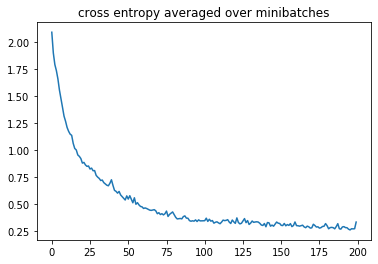

In [122]:
plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()

In [123]:
model.eval()
# Convert a list of tuples to two lists
test_X, test_Y = map(list, zip(*testset))
test_bg = dgl.batch(test_X)
test_Y = torch.tensor(test_Y).float().view(-1, 1)
probs_Y = torch.softmax(model(test_bg), 1)
sampled_Y = torch.multinomial(probs_Y, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
    (test_Y == sampled_Y.float()).sum().item() / len(test_Y) * 100))
print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
    (test_Y == argmax_Y.float()).sum().item() / len(test_Y) * 100))

Accuracy of sampled predictions on the test set: 78.7500%
Accuracy of argmax predictions on the test set: 80.000000%


DGLGraph(num_nodes=468, num_edges=3446,
         ndata_schemes={'h': Scheme(shape=(256,), dtype=torch.float32)}
         edata_schemes={})